In [3]:
!pip install tensorflow

     |████████████████████████████████| 207.1 MB 41 kB/s  eta 0:00:01   |█                               | 6.8 MB 1.4 MB/s eta 0:02:23     |███▎                            | 21.4 MB 3.7 MB/s eta 0:00:50     |█████▉                          | 37.7 MB 6.7 MB/s eta 0:00:26     |██████                          | 38.5 MB 6.7 MB/s eta 0:00:26     |█████████▎                      | 59.8 MB 3.8 MB/s eta 0:00:39     |█████████▍                      | 60.6 MB 3.8 MB/s eta 0:00:39     |█████████▊                      | 63.2 MB 3.8 MB/s eta 0:00:38     |██████████████                  | 91.0 MB 5.7 MB/s eta 0:00:21     |██████████████████              | 116.2 MB 3.3 MB/s eta 0:00:28     |█████████████████████▏          | 137.1 MB 6.4 MB/s eta 0:00:11     |███████████████████████         | 149.3 MB 8.2 MB/s eta 0:00:08
     |████████████████████████████████| 4.2 MB 12.3 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 5.1 MB/s  eta 0:00:01
     |████████████████████████████████| 42 kB

In [119]:
import tensorflow as tf
import numpy as np
import pandas as pd
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances

from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib inline

# Задание 1 (3 балла)

Обучите word2vec модели с негативным семплированием (cbow и skip-gram) с помощью tensorflow аналогично тому, как это было сделано в семинаре. Вам нужно изменить следующие пункты: 1) добавьте лемматизацию в предобработку (любым способом)
2) измените размер окна на 6 для cbow и 12 для skip gram (обратите внимание, что размер окна = #слов слева + #слов справа, в gen_batches в семинаре window не так используется)
3) измените часть с np.random.randint(vocab_size) так, чтобы случайные негативные примеры выбирались обратно пропорционально частотностям слов (частотные должны выбираться реже, а редкие чаще)

Выберете несколько не похожих по смыслу слов, и протестируйте полученные эмбединги (найдите ближайшие слова и оцените правильность, как в семинаре)

In [120]:
wiki = open('wiki_data.txt').read().split('\n')

### Prepocessing

In [36]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [37]:
def lemmatize(token):
    return morph.parse(token)[0].normal_form

def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    tokens = [lemmatize(token) for token in tokens]
    return tokens

In [204]:
vocab = Counter()

for text in wiki:
    vocab.update(preprocess(text))

In [205]:
len(vocab)

356181

In [206]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [228]:
word2id = { 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [229]:
len(word2id)

11988

In [210]:
id2word = {i:word for word, i in word2id.items()}

In [211]:
len(id2word)

11988

In [212]:
sentences = []

for text in wiki:
    tokens = preprocess(text)
    ids = [word2id[token] for token in tokens if token in word2id]
    sentences.append(ids)

In [213]:
probs = dict()
summ = 0
for word in word2id.keys():
    summ += vocab[word]
for word in word2id.keys():
    probs[word] = (vocab[word] / summ)

In [214]:
len(probs)

11988

In [215]:
probs_id = dict()
for word in id2word.keys():
    probs_id[word] = probs[id2word[word]]

In [216]:
len(probs_id)

11988

In [217]:
inverse_probability = [(1-x) for x in probs_id.values()]
inverse_probability = [x/sum(inverse_probability) for x in inverse_probability]

In [80]:
from random import random
from bisect import bisect

In [218]:
def weighted_choice(values, weights):
    total = 0
    cum_weights = []
    for w in weights:
        total += w
        cum_weights.append(total)
    x = random() * total
    i = bisect(cum_weights, x)
    return values[i]

In [219]:
weighted_choice(list(probs_id.keys()), inverse_probability)

3772

### CBOW

In [220]:
X = []
y = []

window = 3
for sent in sentences[:10000]:
    for i in range(len(sent)-1):
        word = sent[i]
        context = sent[max(0, i-window):i] + sent[i+1:i+window]
        
        X.append(context)
        y.append(word)

In [221]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=10, padding='post')
y = np.array(y)

In [222]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [230]:
def gen_batches_cbow(sentences, probs_id, inverse_probability, window = 3, batch_size=1000):
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-window):i] + sent[i+1:i+window]

                X_target.append(word)
                X_context.append(context)
                y.append(1)

                X_target.append(np.random.choice(list(probs_id.keys()), p=list(inverse_probability)))
                X_context.append(context)
                y.append(0)

                if len(X_target) == batch_size:
                    X_target = np.array(X_target)
                    X_context = tf.keras.preprocessing.sequence.pad_sequences(X_context, maxlen=window*2)
                    y = np.array(y)
                    yield ((X_target, X_context), y)
                    X_target = []
                    X_context = []
                    y = []

In [231]:
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(10,))


embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(embeddings_context)
dot = tf.keras.layers.Dot(1)([target, context])

outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

model = tf.keras.Model(inputs=[inputs_target, inputs_context], 
                       outputs=outputs)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [232]:
model.fit(gen_batches_cbow(sentences[:10000], probs_id=probs_id, inverse_probability=inverse_probability, window=3),
          validation_data=gen_batches_cbow(sentences[10000:],  probs_id=probs_id, inverse_probability=inverse_probability, window=3),
          batch_size=1000,
          steps_per_epoch=5000,
          validation_steps=30,
         epochs=2)

Epoch 1/2
5000/5000 [==============================] - 6390s 1s/step - loss: 0.3586 - accuracy: 0.8454 - val_loss: 0.3033 - val_accuracy: 0.8773
Epoch 2/2
5000/5000 [==============================] - 6716s 1s/step - loss: 0.2373 - accuracy: 0.9021 - val_loss: 0.3220 - val_accuracy: 0.8738


In [233]:
embeddings_cbow

array([[ 0.0464662 ,  0.04117003,  0.00748137, ...,  0.01296938,
         0.02333159, -0.00398258],
       [-0.04407486, -0.03842119,  0.00643934, ..., -0.00542885,
        -0.03787053, -0.0495595 ],
       [-0.03655779, -0.04601256, -0.01318984, ..., -0.03524858,
        -0.04634327, -0.03450954],
       ...,
       [-0.02512736,  0.03204944, -0.01609343, ..., -0.01847487,
        -0.00522197,  0.0364614 ],
       [ 0.0124413 , -0.02985858, -0.01330297, ..., -0.00751491,
        -0.04469   , -0.02433776],
       [ 0.00746178,  0.00550408,  0.04247456, ..., -0.04270409,
         0.03684458, -0.01659775]], dtype=float32)

In [234]:
def most_similar(word, embeddings):
    similar = [id2word[i] for i in 
               cosine_distances(embeddings[word2id[word]].reshape(1, -1), embeddings).argsort()[0][:10]]
    return similar

In [235]:
most_similar('окно', embeddings_cbow)

['окно',
 'сбор',
 'оппонент',
 'ганс',
 'стивенс',
 'опера',
 'департамент',
 'преимущественно',
 'декабрь',
 '£']

In [239]:
most_similar('кот', embeddings_cbow)

['кот',
 'предлагать',
 'бакунин',
 '9-й',
 'узбекистан',
 'мотив',
 'вывоз',
 'прибыть',
 'исполнить',
 'group']

In [240]:
most_similar('город', embeddings_cbow)

['город',
 'капелла',
 'охранять',
 '1864',
 'фигурист',
 'блокировать',
 'надо',
 'македония',
 'болеть',
 'единица']

### Skip gram 

In [78]:
X = []
y = []

window = 6
for sent in sentences[:1000]:
    for i in range(len(sent)-1):
        word = sent[i] # target
        
        context = sent[max(0, i-window):i] + sent[i+1:i+window] 

        for context_word in context:
            X.append(word)
            y.append(context_word)

In [79]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [93]:
def gen_batches_sg(sentences, probs_id, inverse_probability, window = 6, batch_size=1000):
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-window):i] + sent[i+1:i+window]
                for context_word in context:
                    X_target.append(word)
                    X_context.append(context_word)
                    y.append(1)
                    
                    X_target.append(word)
                    X_context.append(weighted_choice(list(probs_id.keys()), inverse_probability))
                    y.append(0)
                    
                    if len(X_target) >= batch_size:
                        X_target = np.array(X_target)
                        X_context = np.array(X_context)
                        y = np.array(y)
                        yield ((X_target, X_context), y)
                        X_target = []
                        X_context = []
                        y = []

In [95]:
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(1,))


embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Flatten()(embeddings_context)

dot = tf.keras.layers.Dot(1)([target, context])
outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

model = tf.keras.Model(inputs=[inputs_target, inputs_context], 
                       outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [96]:
model.fit(gen_batches_sg(sentences[:15000], probs_id=probs_id, inverse_probability=inverse_probability, window=6),
          validation_data=gen_batches_sg(sentences[15000:], probs_id=probs_id, inverse_probability=inverse_probability, window=6),
          batch_size=1000,
          steps_per_epoch=5000,
          validation_steps=30,
         epochs=2)

Epoch 1/2
5000/5000 [==============================] - 4219s 844ms/step - loss: 0.4615 - accuracy: 0.7877 - val_loss: 0.4573 - val_accuracy: 0.7897
Epoch 2/2
5000/5000 [==============================] - 4107s 822ms/step - loss: 0.4264 - accuracy: 0.8146 - val_loss: 0.4990 - val_accuracy: 0.7674


In [135]:
embeddings_sg

array([[ 0.03482859, -0.02956803, -0.00371065, ..., -0.00815315,
        -0.0448302 , -0.04319881],
       [ 0.01334755, -0.18266134,  0.2607386 , ..., -0.14163136,
        -0.1567577 , -0.18487763],
       [ 0.01021713,  0.03332259, -0.04486002, ..., -0.05881575,
         0.10570815, -0.03603128],
       ...,
       [ 0.02594272,  0.00636439,  0.04116179, ..., -0.02128221,
        -0.043621  , -0.04552773],
       [-0.01464182,  0.06716199, -0.02285857, ..., -0.06867998,
         0.00737145, -0.0313918 ],
       [-0.05586654,  0.05969387, -0.15152314, ..., -0.07764118,
         0.10195328,  0.02472008]], dtype=float32)

In [145]:
most_similar('окно', embeddings_sg)

['окно',
 'сохранил',
 'бледно',
 'советника',
 'знает',
 'кандидатом',
 'костюм',
 'устья',
 'тираж',
 'скалы']

In [250]:
most_similar('кот', embeddings_sg)

['кот',
 '«когда',
 'конёк',
 'сравнивать',
 'косово',
 'ракетный',
 'взаимодействие',
 'огонь',
 'символический',
 'указывать']

In [150]:
most_similar('город', embeddings_sg)

['город',
 'маркса',
 'спектакле',
 'колледж',
 'марки',
 'петрика',
 'участники',
 '53',
 'певицы',
 'красными']

#### Результаты

Результаты обеих моделей выглядят не очень впечатляюще :( Наверное, это связано с тем, что мы поменяли частотность (искали наименее частотные слова)... Видимо, в таком случае и CBOW, и skip-gram плохо справляются.

# Задание 2 (3 балла)

Обучите 1 word2vec и 1 fastext модель в gensim. В каждой из модели нужно задать все параметры, которые мы разбирали на семинаре. Заданные значения должны отличаться от дефолтных и от тех, что мы использовали на семинаре.

In [241]:
import gensim

In [242]:
wiki = open('wiki_data.txt').read().split('\n')

In [243]:
texts = [preprocess(sent) for sent in wiki] # такой же preprocessing как в 1 задании (с лемматизацией)

### word2vec

In [244]:
w2v = gensim.models.Word2Vec(texts)

In [245]:
w2v = gensim.models.Word2Vec(texts, 
                             vector_size=200, 
                             min_count=15, 
                             max_vocab_size=10000,
                             ns_exponent=0.95,
                             sg=0, 
                             hs=1,
                             negative=7,
                             sample=1e-4,
                             cbow_mean=2,
                             window=4,
                             epochs=9)

In [246]:
w2v.wv.most_similar('город')

[('посёлок', 0.48544546961784363),
 ('столица', 0.47791996598243713),
 ('центр', 0.43370017409324646),
 ('окраина', 0.42700716853141785),
 ('округ', 0.4022160768508911),
 ('район', 0.39803963899612427),
 ('близ', 0.3927867114543915),
 ('городок', 0.38611865043640137),
 ('регион', 0.37758299708366394),
 ('провинция', 0.3706863820552826)]

### FastText

In [247]:
ft = gensim.models.FastText(texts)

In [248]:
ft = gensim.models.FastText(texts, 
                            min_n=5, 
                            max_n=9,
                            vector_size=200, 
                            min_count=15, 
                            max_vocab_size=10000,
                            ns_exponent=0.95,
                            sg=0, 
                            hs=1,
                            negative=7,
                            sample=1e-4,
                            cbow_mean=2,
                            window=4,
                            epochs=9
                           )

In [249]:
ft.wv.most_similar('город')

[('столица', 0.6029025912284851),
 ('городок', 0.5638772249221802),
 ('посёлок', 0.5025506615638733),
 ('центр', 0.5010461211204529),
 ('близ', 0.4815688729286194),
 ('округ', 0.4643416106700897),
 ('район', 0.4493108093738556),
 ('окраина', 0.42306315898895264),
 ('регион', 0.4223270118236542),
 ('провинция', 0.4209226369857788)]

# Задание 3 (4 балла)

Используя датасет для классификации (labeled.csv) и простую нейронную сеть (последняя модель в семинаре), оцените качество полученных эмбедингов в задании 1 и 2 (4 набора эмбедингов), также проверьте 1 любую из предобученных моделей с rus-vectores (но только не tayga_upos_skipgram_300_2_2019). Какая модель показывает наилучший результат?

Убедитесь, что для каждой модели вы корректно воспроизводите пайплайн предобработки (в 1 задании у вас лемматизация, не забудьте ее применить к датасету для классификации; у выбранной предобученной модели может быть своя специфичная предобработка - ее нужно воспроизвести)

In [252]:
data = pd.read_csv('labeled.csv')

In [360]:
data.shape

(14412, 6)

### Preprocessing

In [361]:
data['norm_text'] = data.comment.apply(preprocess)

In [362]:
vocab_lab = Counter()

for text in data['norm_text']:
    vocab_lab.update(text)

In [363]:
filtered_vocab_lab = set()

for word in vocab_lab:
    if vocab_lab[word] > 5:
        filtered_vocab_lab.add(word)

In [364]:
len(filtered_vocab_lab)

6309

In [365]:
word2id_lab = { 'PAD':0}

for word in filtered_vocab_lab:
    word2id_lab[word] = len(word2id_lab)

In [366]:
len(word2id_lab)

6310

In [367]:
id2word_lab = {i:word for word, i in word2id_lab.items()}

In [368]:
len(id2word_lab)

6310

In [369]:
X = []
X = []

for tokens in data['norm_text']:
    ids = [word2id_lab[token] for token in tokens if token in word2id_lab]
    X.append(ids)

In [370]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=150)
y = data.toxic.values

In [371]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

## Эмбеддинги из 1 задания

### CBOW

In [375]:
weights_cbow = np.zeros((len(word2id_lab), 300))

for word, i in word2id_lab.items():

    if word == 'PAD':
        continue

    try:
        weights_cbow[i] = embeddings_cbow[word2id[word]]
    
    except KeyError:
        continue
        weights_cbow[i] = embeddings_cbow[word2id['опрагпллирао']]

In [376]:
inputs = tf.keras.layers.Input(shape=(100,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id_lab), output_dim=300, 
                                       trainable=False,
                                       weights=[weights_cbow])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
          epochs=30)

In [ ]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Skip gram

In [302]:
weights_sg = np.zeros((len(word2id_lab), 300))

for word, i in word2id_lab.items():

    if word == 'PAD':
        continue

    try:
        weights_sg[i] = embeddings_sg[word2id[word]]
    
    except KeyError:
        continue
        weights_sg[i] = embeddings_sg[word2id['опрагпллирао']]

In [305]:
inputs = tf.keras.layers.Input(shape=(100,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id_lab), output_dim=300, 
                                       trainable=False,
                                       weights=[weights_sg])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
          epochs=30)

In [ ]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Эмбеддинги из 2 задания (gensim)

### word2vec

In [314]:
weights_w2v = np.zeros((len(word2id_lab), 200))

for word, i in word2id_lab.items():

    if word == 'PAD':
        continue

    try:
        weights_w2v[i] = w2v.wv[word]
    
    except KeyError:
        continue
        weights_w2v[i] = w2v.wv['опрагпллирао']

In [315]:
inputs = tf.keras.layers.Input(shape=(100,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id_lab), output_dim=200, 
                                       trainable=False,
                                       weights=[weights_w2v])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
          epochs=30)

In [ ]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Fastext

In [378]:
weights_ft = np.zeros((len(word2id_lab), 200))

for word, i in word2id_lab.items():

    if word == 'PAD':
        continue

    try:
        weights_ft[i] = ft.wv[word]
    
    except KeyError:
        continue
        weights_ft[i] = ft.wv['опрагпллирао']

In [379]:
inputs = tf.keras.layers.Input(shape=(100,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id_lab), output_dim=200, 
                                       trainable=False,
                                       weights=[weights_ft])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
          epochs=30)

In [ ]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Предобученная модель с Rus vectores

Скачаем **ruscorpora_upos_cbow_300_20_2019** с rusvectores (https://rusvectores.org/ru/models/)

In [318]:
from pymystem3 import Mystem
m = Mystem()

In [331]:
def tag_mystem(text):  # from https://github.com/akutuzov/webvectors/blob/master/preprocessing/rusvectores_tutorial.ipynb

    processed = m.analyze(text)
    tagged = []
    for w in processed:
        if "analysis" not in w:
            continue
        
        if not len(w["analysis"]):
            lemma = w["text"]
            pos = "UNKN"
        else:
            lemma = w["analysis"][0]["lex"].lower().strip()
            pos = w["analysis"][0]["gr"].split(',')[0]
            pos = pos.split('=')[0].strip()
        tagged.append(lemma.lower() + '_' + pos)
      
    return tagged

In [332]:
from gensim.models import KeyedVectors

In [334]:
data['tag_mystem'] = data.comment.apply(tag_mystem)

In [335]:
data.sample(5)

,comment,toxic,norm_text,preprocessed,preprocessed_mystem,tag_mystem
10116,ну так лицензией это никогда и не было. Неудив...,0.0,"[ну, так, лицензия, это, никогда, и, не, быть,...","[ну, так, лицензия, это, никогда, и, не, быть,...","[ну_PART, так_ADVPRO, лицензия_S, это_PART, ни...","[ну_PART, так_ADVPRO, лицензия_S, это_PART, ни..."
1262,"Ну тут, имхо, от магазина конкретного зависит ...",0.0,"[ну, тут, имхо, от, магазин, конкретный, завис...","[ну, тут, имхо, от, магазин, конкретный, завис...","[ну_PART, тут_ADVPRO, имхо_ADV, от_PR, магазин...","[ну_PART, тут_ADVPRO, имхо_ADV, от_PR, магазин..."
3676,"Балбес твой дед, олень\n",1.0,"[балбес, твой, дед, олень]","[балбес, твой, дед, олень]","[балбес_S, твой_APRO, дед_S, олень_S]","[балбес_S, твой_APRO, дед_S, олень_S]"
7911,Ну владелец то один. Что мешает передать телеф...,0.0,"[ну, владелец, то, один, что, мешать, передать...","[ну, владелец, то, один, что, мешать, передать...","[ну_PART, владелец_S, то_PART, один_APRO, что_...","[ну_PART, владелец_S, то_PART, один_APRO, что_..."
7446,сколько осталось до следующего крушения?\n,0.0,"[сколько, остаться, до, следующий, крушение]","[сколько, остаться, до, следующий, крушение]","[сколько_ADV, оставаться_V, до_PR, следующий_A...","[сколько_ADV, оставаться_V, до_PR, следующий_A..."


In [336]:
vocab_rv = Counter()

for text in data.tag_mystem:
    vocab_rv.update(text)

In [337]:
len(vocab_rv)

32925

In [338]:
word2id_rv = {'PAD': 0}

for word in vocab_rv:
    word2id_rv[word] = len(word2id_rv)

In [340]:
len(word2id_rv)

32926

In [339]:
id2word_rv = {i: word for word, i in word2id_rv.items()}

In [341]:
len(id2word_rv)

32926

In [342]:
X = []

for tokens in data.tag_mystem:
    ids = [word2id_rv[token] for token in tokens if token in word2id_rv]
    X.append(ids)

In [343]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=100)
y = data.toxic.values

In [344]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)

In [345]:
model = KeyedVectors.load_word2vec_format('model.bin', binary=True)

In [346]:
weights_rv = np.zeros((len(word2id_rv), 300))

for word, i in word2id_rv.items():

    if word == 'PAD':
        continue

    try:
        weights_rv[i] = model[word]
    
    except KeyError:
        continue
        weights_rv[i] = model['опрагпллирао']

In [347]:
inputs = tf.keras.layers.Input(shape=(100,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id_rv), output_dim=300, 
                                       trainable=False,
                                       weights=[weights_rv])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [348]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
          epochs=30)

Epoch 1/30
406/406 [==============================] - 3s 4ms/step - loss: 0.6330 - accuracy: 0.6651 - val_loss: 0.6117 - val_accuracy: 0.6567
Epoch 2/30
406/406 [==============================] - 2s 4ms/step - loss: 0.6031 - accuracy: 0.6661 - val_loss: 0.6068 - val_accuracy: 0.6567
Epoch 3/30
406/406 [==============================] - 2s 5ms/step - loss: 0.5987 - accuracy: 0.6662 - val_loss: 0.6056 - val_accuracy: 0.6574
Epoch 4/30
406/406 [==============================] - 2s 6ms/step - loss: 0.5964 - accuracy: 0.6665 - val_loss: 0.6048 - val_accuracy: 0.6588
Epoch 5/30
406/406 [==============================] - 2s 5ms/step - loss: 0.5948 - accuracy: 0.6666 - val_loss: 0.6043 - val_accuracy: 0.6595
Epoch 6/30
406/406 [==============================] - 2s 5ms/step - loss: 0.5935 - accuracy: 0.6668 - val_loss: 0.6041 - val_accuracy: 0.6609
Epoch 7/30
406/406 [==============================] - 3s 7ms/step - loss: 0.5925 - accuracy: 0.6665 - val_loss: 0.6037 - val_accuracy: 0.6616
Epoch 

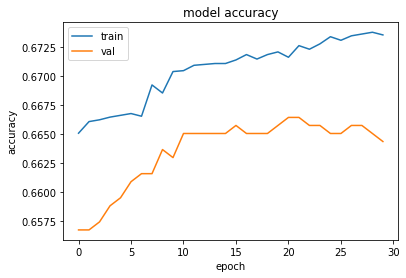

In [349]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()